<a href="https://colab.research.google.com/github/ani-101/MachineTranslation/blob/main/NewMachineTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation - Eng to Bhoj


---



---



Import libraries

In [1]:
import numpy as np
import re
import pickle
import os
import seaborn as sns
import string
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split
import nltk
import tensorflow as tf
from unicodedata import normalize
from numpy import array
from numpy.random import shuffle
from pickle import dump,load
from numpy.random import shuffle
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,LSTM,Embedding
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


Dataset Extraction

In [4]:

# Read the xlsx file
df = pd.read_excel('Translation_EnglishToBhojpuri.xlsx')

# Display the contents of the file
print(df.head())

# Extract the English and Bhojpuri sentences
english_sentences = df['English'].values
bhojpuri_sentences = df['Bhojpuri'].values

               English                   Bhojpuri
0         How are you?                 का हाल बा?
1          All is well               सब बढ़िया बा
2     Long time to see  बड़ी दिन से भेंट ना भईल ह
3   What is your name?           तोहार नाव् का ह?
4  Where are you from?             तु कहाँ से हव?


## Data Pre-processing

In [5]:
def preprocess(text):
  text = ''.join(ch for ch in text if ch not in string.punctuation)
  text = text.lower()
  text = re.sub(r'\d','',text)
  text = re.sub(r'\s+',' ',text)
  text = text.strip()
  return text

In [6]:
df.shape

(1528, 2)

In [7]:
# spot check
for i in range(10):
  print('[%s] ===>>[%s]' % (english_sentences[i],bhojpuri_sentences[i]))

[How are you?] ===>>[का हाल बा?]
[All is well] ===>>[सब बढ़िया बा]
[Long time to see] ===>>[बड़ी दिन से भेंट ना भईल ह]
[What is your name?] ===>>[तोहार नाव् का ह?]
[Where are you from?] ===>>[तु कहाँ से हव?]
[Nice to meet you] ===>>[तोसे मिल कर अच्छा लगल]
[Good luck] ===>>[किस्मत बढ़िया रहे]
[For good health] ===>>[बढ़िया सेहत के वास्ते]
[Have a nice day] ===>>[बढ़िया दिन रहे]
[Have a good journey] ===>>[सफ़र बढ़िया रहे]


**Splitting of dataset**

In [9]:
n_sentences= 1529
#split = int(0.95 * n_sentences)
train_eng = english_sentences[0:1000]
train_bhojpuri = bhojpuri_sentences[0:1000]
test_eng = english_sentences[1000:]
test_bhojpuri = bhojpuri_sentences[1000:]

In [10]:
train_eng.shape

(1000,)

In [11]:
test_eng.shape

(528,)

In [12]:
train_eng

array(['How are you?', 'All is well', 'Long time to see',
       'What is your name?', 'Where are you from?', 'Nice to meet you',
       'Good luck', 'For good health', 'Have a nice day',
       'Have a good journey', "I don't know", 'I understand',
       "I don't understand", 'Please, say again', 'please, write this',
       'Can you speak Bhojpuri?', 'Yes,little little',
       'Speak to me in Bhojpuri', 'How much is this?', 'Miss you',
       'Get well soon', 'Leave me alone', 'Help me', 'As you tell',
       'As you wish', 'Yes, sure', 'Come here, clean this',
       'Let what it happened', 'Get ready, come soon',
       'Excuse me, I am going to the market', 'I ate a Samosa',
       'I will go home', 'I am going from Delhi to Mumbai',
       'I am going by train', 'I eat fruits daily',
       'I eat fruits at 4 p.m. in the evening',
       'I eat fruits after cutting them in the office',
       'I have two apples', 'This apple is not mine',
       'The apple that I had kept in th

In [13]:
test_bhojpuri

array(['कंपनी के स्थायित्व के प्रति प्रतिबद्धता दोसरा खातिर एगो सकारात्मक उदाहरण पेश करेला।',
       'हालांकि बहुत मुद्दा प दुनो लोग के बीच मतभेद रहे लेकिन ए खास मुद्दा प दुनो लोग के आम बात मिलल',
       'शेफ के सामग्री के अभिनव इस्तेमाल से सही मायने में एगो अनोखा पाक अनुभव पैदा भईल',
       'भाषा के बाधा के बावजूद इशारा आ अभिव्यक्ति के माध्यम से प्रभावी ढंग से संवाद करत रहले',
       'फिल्म के जटिल कथानक के मोड़ देख के दर्शक एकदम अंत ले अंदाजा लगावत रहले.',
       'हालांकि ई एगो कठिन काम रहे बाकिर टीम वर्क आ दृढ़ संकल्प से एकरा के पूरा करे में कामयाब रहलें.',
       'एह एथलीट के प्रशिक्षण खातिर समर्पण के फल मिलल आ ओलंपिक में स्वर्ण पदक मिलल.',
       'बाधा के बावजूद एक दूसरा से प्यार अटूट रहे।',
       'वैज्ञानिक के एह अभूतपूर्व शोध से एह क्षेत्र में क्रांति ले आवे के क्षमता बा।',
       'हालांकि ई लोग अलग अलग पृष्ठभूमि से आइल रहे बाकिर एह लोग के एगो साझा लक्ष्य रहे कि बदलाव ले आवल जाव',
       'प्राचीन खंडहर सभ्यता के समृद्ध इतिहास के झलक देत रहे',
       'आलोचना के बावजूद उ अपना कला

In [14]:
#create a tokenizer
def create_tokenizer(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [15]:
# max length
def max_length(lines):
  return max(len(line.split()) for line in lines)

In [16]:
#Encoding and padding the sequences
def encode_sequences(tokenizer,length,lines):
  # integer encode sequences
  X = tokenizer.texts_to_sequences(lines)
  # pad sequenses
  x_pad = pad_sequences(X,padding='post',maxlen=length)
  return x_pad

In [17]:
def encode_output(sequences,vocab_size):
  ylist = list()
  for seq in sequences:
    encoded = to_categorical(seq,num_classes=vocab_size)
    ylist.append(encoded)
  y = array(ylist)
  #print(y)
  y = y.reshape(sequences.shape[0],sequences.shape[1], vocab_size)
  return y

In [18]:
eng_tokenizer = create_tokenizer(english_sentences)
eng_vocab_size = len(eng_tokenizer.word_index)+1
eng_length = max_length(english_sentences)
print('English vocabualry size is %d' % (eng_vocab_size))
print('English Max Lengthh is %d' % (eng_length))


English vocabualry size is 4801
English Max Lengthh is 41


In [19]:
print(eng_tokenizer.word_index)

{'the': 1, 'and': 2, 'a': 3, 'to': 4, 'of': 5, 'in': 6, 'is': 7, 'for': 8, 'with': 9, 'it': 10, 'on': 11, 'was': 12, 'that': 13, 'they': 14, 'are': 15, 'we': 16, 'as': 17, 'she': 18, 'he': 19, 'i': 20, 'be': 21, 'from': 22, 'new': 23, 'their': 24, 'you': 25, 'have': 26, 'his': 27, 'by': 28, 'indian': 29, 'can': 30, 'has': 31, 'her': 32, 'will': 33, 'had': 34, 'despite': 35, 'india': 36, 'at': 37, 'although': 38, 'like': 39, 'were': 40, 'an': 41, 'after': 42, 'its': 43, 'work': 44, 'use': 45, 'or': 46, 'this': 47, 'not': 48, 'our': 49, 'way': 50, 'also': 51, 'enabling': 52, 'made': 53, 'but': 54, 'intricate': 55, 'time': 56, 'people': 57, 'more': 58, 'lord': 59, 'your': 60, 'up': 61, 'art': 62, 'data': 63, 'because': 64, 'paragraph': 65, 'my': 66, 'different': 67, 'many': 68, 'which': 69, 'well': 70, 'experience': 71, 'writing': 72, 'long': 73, 'world': 74, 'all': 75, 'every': 76, 'who': 77, 'been': 78, 'day': 79, 'years': 80, 'through': 81, 'about': 82, 'what': 83, 'important': 84, 'hu

In [20]:
bhoj_tokenizer = create_tokenizer(bhojpuri_sentences)
bhoj_vocab_size = len(bhoj_tokenizer.word_index)+1
bhoj_length = max_length(bhojpuri_sentences)
print('Bhojpuri vocabualry size is %d' % (bhoj_vocab_size))
print('Bhojpuri Max Lengthh is %d' % (bhoj_length))

Bhojpuri vocabualry size is 4598
Bhojpuri Max Lengthh is 54


In [21]:
print(bhoj_tokenizer.word_index)

{'के': 1, 'में': 2, 'आ': 3, 'से': 4, 'बा': 5, 'एगो': 6, 'खातिर': 7, 'करे': 8, 'लोग': 9, 'कि': 10, 'पर': 11, 'बा।': 12, 'हो': 13, 'अपना': 14, 'हमनी': 15, 'रहल': 16, 'उ': 17, 'रहे': 18, 'जवना': 19, 'ऊ': 20, 'सभ': 21, 'अवुरी': 22, 'ना': 23, 'कर': 24, 'वाला': 25, 'एह': 26, 'काम': 27, 'भारत': 28, 'जा': 29, 'नया': 30, 'रहे।': 31, 'का': 32, 'इस्तेमाल': 33, 'जवन': 34, 'तरीका': 35, 'ले': 36, 'कइल': 37, 'जाला।': 38, 'गइल': 39, 'भी': 40, 'भारतीय': 41, 'ई': 42, 'रूप': 43, 'अलग': 44, 'बावजूद': 45, 'होखे': 46, 'बाद': 47, 'बहुत': 48, 'आपन': 49, 'हम': 50, 'जटिल': 51, 'हालांकि': 52, 'सके': 53, 'लेकिन': 54, 'बनावे': 55, 'एकरा': 56, 'प': 57, 'करत': 58, 'सक्षम': 59, 'खाना': 60, 'बानी': 61, 'कवनो': 62, 'बॉलीवुड': 63, 'पूरा': 64, 'चलते': 65, 'हवे।': 66, 'जाला': 67, 'बनावल': 68, 'ह': 69, 'समय': 70, 'एक': 71, 'तक': 72, 'कुछ': 73, 'उनुका': 74, 'बढ़िया': 75, 'दिहल': 76, 'सकेला': 77, 'रउरा': 78, 'भगवान': 79, 'त': 80, 'बदलाव': 81, 'पैराग्राफ': 82, 'भर': 83, 'होला': 84, 'जरूरत': 85, 'कम': 86, 'अनुभव': 87, 'शामिल':

In [22]:
# preparing training data
trainX = encode_sequences(eng_tokenizer,eng_length,train_eng)
trainY = encode_sequences(bhoj_tokenizer,bhoj_length,train_bhojpuri)


In [ ]:
trainX

array([[    4,  1848,   133, ...,     0,     0,     0],
       [    1,  1330,   151, ...,     0,     0,     0],
       [    1,    87,   246, ...,     0,     0,     0],
       ...,
       [ 2064, 16179,    36, ...,     0,     0,     0],
       [   50,    21,   372, ...,     0,     0,     0],
       [ 2112,    44,  9284, ...,     0,     0,     0]], dtype=int32)

In [ ]:
trainY

array([[  279,   429,     2, ...,     0,     0,     0],
       [ 1915,   785,     1, ...,     0,     0,     0],
       [  108,   244,  1045, ...,     0,     0,     0],
       ...,
       [19202,  5309,  6900, ...,     0,     0,     0],
       [ 1469,   317,    10, ...,     0,     0,     0],
       [  185,  1770,    31, ...,     0,     0,     0]], dtype=int32)

In [23]:
trainY = encode_output(trainY,bhoj_vocab_size)

In [ ]:
trainY

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0.

In [24]:
# preparing training data
testX = encode_sequences(eng_tokenizer,eng_length,test_eng)
testY = encode_sequences(bhoj_tokenizer,bhoj_length,test_bhojpuri)
testY = encode_output(testY,bhoj_vocab_size)

# LSTM Model

In [25]:
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
# define the NMT model
def define_model(src_vocab, tar_vocab, src_timestep, tar_timestep, n_units):
  model = Sequential()
  model.add(Embedding(src_vocab,n_units,input_length=src_timestep,mask_zero=True))
  model.add(LSTM(n_units))
  model.add(RepeatVector(tar_timestep))
  model.add(LSTM(n_units,return_sequences=True))
  model.add(TimeDistributed(Dense(tar_vocab,activation='softmax')))

  # compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

  # summary of the model
  model.summary()

  return model

In [26]:
from keras.callbacks import ModelCheckpoint
# fit the model
path_save_model_trans='/content/trained_model.h5'
checkpoint = ModelCheckpoint(path_save_model_trans,monitor='val_loss',verbose=1, save_best_only=True, mode='min')

In [28]:
model_trans = define_model(eng_vocab_size, bhoj_vocab_size, eng_length, bhoj_length, 128)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 41, 128)           614528    
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 repeat_vector_1 (RepeatVec  (None, 54, 128)           0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 54, 128)           131584    
                                                                 
 time_distributed_1 (TimeDi  (None, 54, 4598)          593142    
 stributed)                                                      
                                                                 
Total params: 1470838 (5.61 MB)
Trainable params: 1470

In [29]:
model_trans.fit(trainX,trainY,epochs=20,batch_size=64,validation_data=(testX,testY), callbacks=[checkpoint],verbose=True)

Epoch 1/20
16/16 [==============================] - ETA: 0s - loss: 7.7916 - accuracy: 0.6111
Epoch 1: val_loss improved from inf to 5.79895, saving model to /content/trained_model.h5
16/16 [==============================] - 21s 433ms/step - loss: 7.7916 - accuracy: 0.6111 - val_loss: 5.7990 - val_accuracy: 0.7233
Epoch 2/20


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - ETA: 0s - loss: 4.2279 - accuracy: 0.6645
Epoch 2: val_loss improved from 5.79895 to 2.74697, saving model to /content/trained_model.h5
16/16 [==============================] - 3s 187ms/step - loss: 4.2279 - accuracy: 0.6645 - val_loss: 2.7470 - val_accuracy: 0.7233
Epoch 3/20
16/16 [==============================] - ETA: 0s - loss: 2.8639 - accuracy: 0.6645
Epoch 3: val_loss improved from 2.74697 to 2.60043, saving model to /content/trained_model.h5
16/16 [==============================] - 2s 152ms/step - loss: 2.8639 - accuracy: 0.6645 - val_loss: 2.6004 - val_accuracy: 0.7233
Epoch 4/20
16/16 [==============================] - ETA: 0s - loss: 2.8213 - accuracy: 0.6645
Epoch 4: val_loss did not improve from 2.60043
16/16 [==============================] - 2s 123ms/step - loss: 2.8213 - accuracy: 0.6645 - val_loss: 2.6448 - val_accuracy: 0.7233
Epoch 5/20
16/16 [==============================] - ETA: 0s - loss: 2.7515 - accuracy: 0.6645
Epoch 5

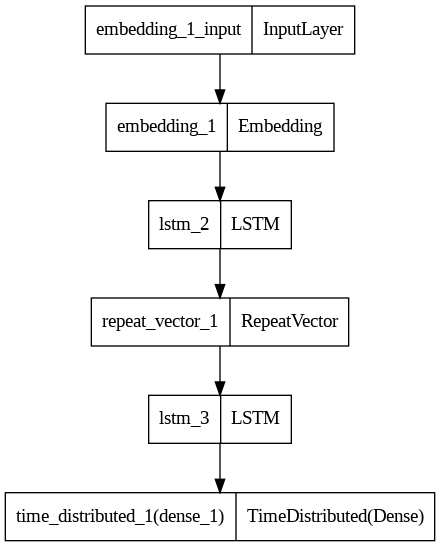

In [30]:
import keras
from keras.utils import plot_model
plot_model(model_trans)

# Model testing

In [31]:
def word_for_id(integer,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index == integer:
      print("I am word",word)
      return word
  return None

In [32]:
# generate target given sequence
def predict_sequence(model,tokenizer,source):
  prediction = model.predict(source,verbose=0)[0]
  print(prediction)
  integers = [np.argmax(vector) for vector in prediction]
  print(integers)
  target = list()
  for i in integers:
    word = word_for_id(i,tokenizer)
    if word is None:
      break
    target.append(word)
  print(target)
  return " ".join(target)

In [ ]:
# evaluate the skill of all the model
def evaluate_model(model, bhoj_tokenizer,sources, english_sentences,bhojpuri_sentences):
  actual,predicted = list(),list()
  for i,source in enumerate(sources):
    # translate encoded source text
    source = source.reshape((1,source.shape[0]))
    translation = predict_sequence(model,bhoj_tokenizer,source)
    raw_target, raw_src = bhojpuri_sentences[i], english_sentences[i]
    if i < 10:
      print('src=[%s], target=[%s], predicted=[%s]' % (raw_src,raw_target,translation))
    actual.append(raw_target.split())
    predicted.append(translation.split())
  # calculate the BLEU score
  #print('BLEU-1 : %f' % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))

In [ ]:
evaluate_model(model_trans,bhoj_tokenizer,trainX[0:5],english_sentences,bhojpuri_sentences)

[[1.7936883e-03 2.1409320e-03 1.4247838e-03 ... 8.5719839e-05
  9.0644542e-05 9.6509233e-05]
 [2.7196942e-02 1.5433234e-02 6.8318420e-03 ... 2.0874475e-05
  2.4663388e-05 2.6876380e-05]
 [4.6944880e-01 1.9274896e-02 6.7502637e-03 ... 2.9136770e-06
  3.9206761e-06 4.2677661e-06]
 ...
 [9.7633034e-01 1.0069257e-03 3.0025060e-04 ... 3.0371105e-08
  4.8024951e-08 5.0593052e-08]
 [9.7633034e-01 1.0069257e-03 3.0025060e-04 ... 3.0371105e-08
  4.8024951e-08 5.0593052e-08]
 [9.7633034e-01 1.0069257e-03 3.0025060e-04 ... 3.0371105e-08
  4.8024951e-08 5.0593052e-08]]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
I am word के
['के']
src=[How are you?], target=[का हाल बा?], predicted=[के]
[[2.5643236e-03 3.5923123e-03 2.1599855e-03 ... 6.6331966e-05
  7.1091752e-05 7.6323187e-05]
 [3.6257297e-02 2.5602356e-02 1.0078262e-02 ... 1.4093757e-05
  1.6953769e-05 1.8498511e-05]
 [4.5705071